In [1]:
import cv2
from matplotlib.animation import FuncAnimation, writers

In [4]:
import cv2
import os
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

datadir="../video"
cap = cv2.VideoCapture(os.path.join(datadir, "F2_1_1_2.ts"))
if not cap.isOpened():
    print("Cannot open camera")
frames = []
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    # Display the resulting frame
# When everything done, release the capture
cap.release()

Can't receive frame (stream end?). Exiting ...


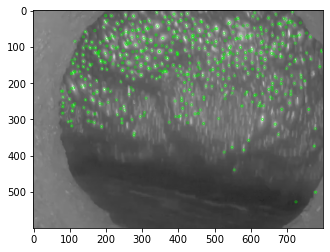

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
# Initiate ORB detector
#orb = cv.ORB_create()
# find the keypoints with ORB
#kp = orb.detect(img,None)
#kp = sift.detect(img,None)
kp, des = sift.detectAndCompute(img,None)
# compute the descriptors with ORB
# kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2);

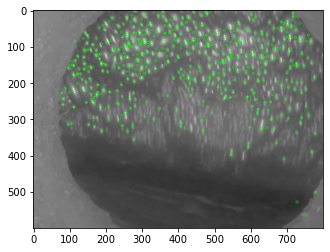

In [6]:
img = cv2.cvtColor(frames[1], cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
# Initiate ORB detector
#orb = cv.ORB_create()
# find the keypoints with ORB
#kp = orb.detect(img,None)
#kp = sift.detect(img,None)
kp1, des1 = sift.detectAndCompute(img,None)
# compute the descriptors with ORB
# kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img2);

In [7]:
des.shape, des1.shape

((662, 128), (665, 128))

In [8]:
#sift = cv2.xfeatures2d.SIFT_create()

In [9]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=8)
knn.fit(des)

NearestNeighbors(n_neighbors=8)

In [10]:
dist, ids = knn.kneighbors(des1, return_distance=True)

(array([ 40.,  70.,  57.,  50.,  39.,  36.,  23.,  29.,  70., 251.]),
 array([0.06921352, 0.1622842 , 0.25535488, 0.34842557, 0.44149625,
        0.53456694, 0.6276376 , 0.72070825, 0.81377894, 0.9068496 ,
        0.9999203 ], dtype=float32),
 <BarContainer object of 10 artists>)

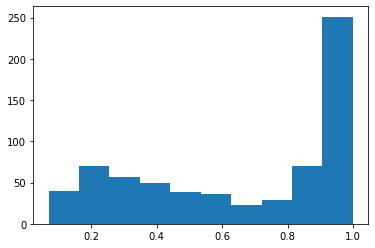

In [11]:
plt.hist(dist[:, 0]/dist[:, 1])

In [12]:
sel_ids = np.where(dist[:, 0]/dist[:, 1] < 0.6)[0]
old_ids = ids[sel_ids, 0]

old_points = np.stack([np.asarray(kp[i].pt) for i in old_ids])

In [13]:
new_points = np.stack([np.asarray(kp1[i].pt) for i in sel_ids])

In [14]:
np.where(np.sqrt(((new_points-old_points)**2).sum(1)) > 67)

(array([], dtype=int64),)

(-0.5, 799.5, 599.5, -0.5)

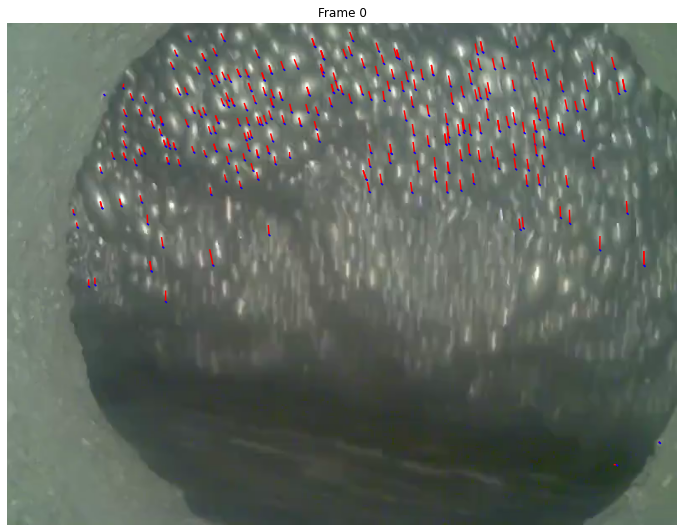

In [15]:
plt.figure(figsize=(6*2, 8*2))
frame = frames[0]
plt.imshow(frame, cmap="Greys", vmin=0, vmax=255)
for o, n in zip(old_points, new_points):
    #print(o)
    plt.plot([o[0], n[0]], [o[1], n[1]], color="red")
    plt.plot([n[0], n[0]+1], [n[1], n[1]+1], color="blue")
    #break
plt.title("Frame 0")
plt.axis("off")


(-0.5, 799.5, 599.5, -0.5)

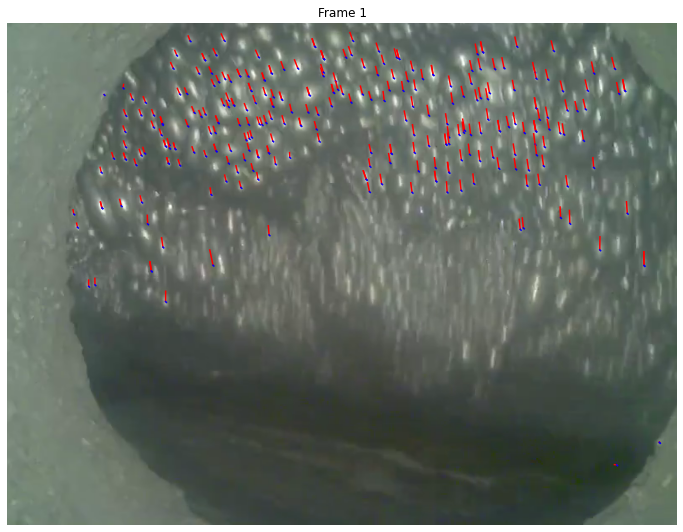

In [16]:
plt.figure(figsize=(6*2, 8*2))
frame = frames[1]
plt.imshow(frame, cmap="Greys", vmin=0, vmax=255)
for o, n in zip(old_points, new_points):
    #print(o)
    plt.plot([o[0], n[0]], [o[1], n[1]], color="red")
    plt.plot([n[0], n[0]+1], [n[1], n[1]+1], color="blue")
    #break
plt.title("Frame 1")
plt.axis("off")


In [23]:
def get_point_pairs(old_frame, new_frame, cutoff=0.8):
    sift = cv2.xfeatures2d.SIFT_create()
    
    old_frame_ = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    new_frame_ = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
    kp0, des0 = sift.detectAndCompute(old_frame_, None)
    kp1, des1 = sift.detectAndCompute(new_frame_, None)
    pos0 = np.stack([np.asarray(k.pt) for k in kp0])
    pos1 = np.stack([np.asarray(k.pt) for k in kp1])
    
    from sklearn.neighbors import NearestNeighbors

    point_knn = NearestNeighbors(n_neighbors=4)
    point_knn.fit(pos0)
    p_ids = point_knn.kneighbors(pos1, return_distance=False) #p_dist, 

    knn = NearestNeighbors(n_neighbors=8)
    knn.fit(des0)
    dist, ids = knn.kneighbors(des1, return_distance=True)
    
    sel_ids = np.where((dist[:, 0]/dist[:, 1] < cutoff) & [(best_point in nn) for best_point, nn in zip(ids[:, 0], p_ids)])[0]
    print(sel_ids.shape)
    old_ids = ids[sel_ids, 0]

    old_p = np.stack([np.asarray(kp0[i].pt) for i in old_ids])
    new_p = np.stack([np.asarray(kp1[i].pt) for i in sel_ids])
    return (old_p, new_p)

In [24]:
all_point_pairs = []
for old_frame, new_frame in tqdm_notebook(zip(frames, frames[1:50])):
    res = get_point_pairs(old_frame, new_frame)
    all_point_pairs.append(res)


/Users/lacemaker/anaconda3/envs/data_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

(311,)
(291,)
(331,)
(332,)
(337,)
(347,)
(378,)
(370,)
(357,)
(42,)
(288,)
(289,)
(313,)
(296,)
(302,)
(276,)
(297,)
(256,)
(256,)
(386,)
(288,)
(425,)
(351,)
(314,)
(365,)
(380,)
(383,)
(400,)
(344,)
(394,)
(295,)
(326,)
(409,)
(343,)
(325,)
(360,)
(352,)
(305,)
(6,)
(3,)
(160,)
(111,)
(122,)
(79,)
(101,)
(125,)
(170,)
(145,)
(160,)


In [25]:
def draw_flux(i):
    old_points, new_points = all_point_pairs[i]
    #plt.figure(figsize=(6, 8))
    # frame0 = frames[i]
    plt.clf()
    frame = frames[i]
    plt.imshow(frame, cmap="Greys", vmin=0, vmax=255)
    for o, n in zip(old_points, new_points):
        #print(o)
        plt.plot([o[0], n[0]], [o[1], n[1]], color="red")
        plt.plot([n[0], n[0]+1], [n[1], n[1]+1], color="blue")
        #break
    plt.title(f"Frame {i}")
    plt.axis("off")
    


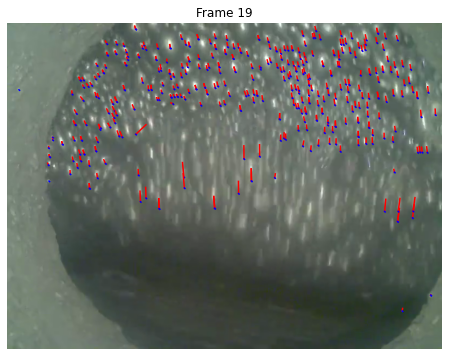

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
#ax.set_xlim(0, 1), 
ax.set_xticks([])
#ax.set_ylim(0, 1), 
ax.set_yticks([])
animation = FuncAnimation(fig, draw_flux, frames=np.arange(0, 20))
Writer = writers['ffmpeg']#['imagemagick']#
writer = Writer(fps=5, metadata={'artist': 'Me'})

animation.save('foambox_bubble.mp4', writer)